Lo primero es el webscrapping

Cargas el siguiente cuadro y en el navegador que se abre vas a la página que deseas leer y luego presionas "Guardar html", le pones el nombre que corresponda según el cuadro de código que lo leerá y ya está, tienes que asegurarte de hacer eso con todas las cuentas

Extrae el html de esta página (primero asegurate de tener activos los filtros que quieres) (click derecho y click en "guardar página como" o en "guardar como html")... No automatizar esto es lo más seguro (y no es ilegal), además de que es quizas más eficiente a largo plazo.

In [16]:
import webbrowser

webbrowser.open("https://www.paypal.com/myaccount/activities/?free_text_search=&start_date=2023-01-01&end_date=2023-03-15&type=&status=&currency=&filter_id=&issuance_product_name=&asset_names=&asset_symbols=")

True

Empezamos las lecturas de los html, cada cuadro lee una cuenta diferente y empezamos por paypal. Al leer los html con bs4 luego se guarda la información seleccionada, organizada y clasificada en un .csv

Algunas cuentas como las del banreservas es mejor solo exportar el csv que te ofrece la página (paypal también ofrece pero me pareció insuficiente así que mejor extraje de un html).

In [3]:
# Importaciones
from bs4 import BeautifulSoup
import pandas as pd


In [31]:
#Leamos, procesemos y despleguemos la informacion de paypal

with open("paypal_trans.html", encoding="utf-8") as ppt:
    ppt_data = ppt.read()
    soup = BeautifulSoup(ppt_data, "html.parser")
    # print(soup.prettify())
    
   #this contains all transactions data of the page
    container = soup.find("div", attrs={"data-testid":"activity-tile"}) #container = soup.find(id="app") takes too much childs
    # print(container.prettify())
     
    #names of the other persons in the transactions. I take the id from the class name of the container of all the transactions, just taking this will be easier than looping from this general container but i will still be able to identify the transaction just in case. Yes, this is the real paypal transation id
    #taking the name and the id together isntead of individual will make this more secure since we can now for sure that the id corresponds to this specific transaction
    counterparties = {}
    cnames = [] #the pandas dataframes does not accepts
    for name in container.findAll('div',
                                 attrs={"data-cy":'counterpartyName'}):
        transaction_id = name.parent.parent.parent.parent["class"][1][19:]
        counterparties[name.text] = transaction_id
        cnames.append(name.text)
    print(counterparties)
    print(cnames)
    
    #dates and info are together, i'll extract and separe them. This way is easier
    dates_no_format = []
    info = [] #type of transaction
    for date in container.findAll('div',
                                  attrs={"transaction-date-type-status-container"}):
        date_info = date.text
        dot = str.find(date_info,"·")
        dates_no_format.append(date_info[:dot])
        info.append(date_info[dot+1:])
    print(info)

    #translate obtaied dates (example "8 mar") to a full and esthetic date
    dates = []
    for date in dates_no_format:
        day, month = date.split()

        # Dictionary with month name abbreviation and corresponding number
        month_dict = {
            'ene': '01',
            'feb': '02',
            'mar': '03',
            'abr': '04',
            'may': '05',
            'jun': '06',
            'jul': '07',
            'ago': '08',
            'sep': '09',
            'oct': '10',
            'nov': '11',
            'dic': '12'
        }

        # Add leading zero to day if necessary
        day = day.zfill(2)

        # Convert month name abbreviation to number
        month_num = month_dict[month.lower()]

        # Format date as DD/MM
        formatted_date = f"{day}/{month_num}"
        dates.append(formatted_date)
        
    print(dates)

    
    #amount of the transactions
    amounts = []
    change = [] #is the amount plus the symbol of subtraction or adittion as corresponds
    for amount in container.findAll('div',
                                 attrs={"data-cy":'transactionAmount'}):
        amounts_change = amount.text
        change.append(amounts_change)
        if amounts_change[len(amounts_change)-1].isdigit() == True: #this is to delete the name of the currency from the end of the number (just in non USD trnasactions)
            amounts.append(amounts_change[2:])
        else:
            amounts.append(amounts_change[2:len(amounts_change)-4])
    print(amounts)
    print(change)
    
    #messages left with the transaction
    messages = {}
    for message in container.findAll('div',
                                 attrs={"data-cy":'notes'}):
        # transaction_id = message.parent.parent.parent.parent["class"][1][19:]
        date_of_message = message.parent.parent.parent.parent.find(
            'div', attrs={"transaction-date-type-status-container"}) #I take the date because is a lot easier to find the index using this (not every transaction have a message)
        messages[date_of_message.text[:str.find(date_of_message.text, ".")+1]] = message.text
    print(messages)
        
    #every transaction have a link to acces to a very more detailed info about them, here is get this link. In the link i can find things like paypal comision, counterparty contact info, counterparty direction and transaction id
    details_links = []
    for counterpart in container.findAll('div',
                                 attrs={"data-cy":'counterpartyName'}): #i take part of the classes name to find them
        details = counterpart.parent.parent.parent.parent
        details_links.append("https://www.paypal.com"+details["data-href"])
    print(details_links)
    
    #Use pandas to create the .csv
    messages2 = [] #lets make the messages dictionary bigger,a list and with the correct index to make it adecuate for the data frame
    for date in dates:
        if date not in messages:
            messages2.append("")
        else:
            messages2.append(messages[date])
    info = {"Nombre": cnames, "Fecha": dates, "Tipo":info, "Cantidad":amounts, "Efecto":change, "Mensaje": messages2,"Detalles":details_links}
    df = pd.DataFrame(data = info)
    print(df)
    df.to_csv('paypal_data.csv')#, index=False, sep="\t")


{'Banco de Reservas de la Republica Dominicana': '28B551335H768814N', 'Uber BV': '12W54441RT095925X', 'FIVERR INTERNATIONAL LTD.': '1HE32494NN681310J'}
['Banco de Reservas de la Republica Dominicana', 'Uber BV', 'Uber BV', 'Uber BV', 'Banco de Reservas de la Republica Dominicana', 'Uber BV', 'Uber BV', 'Uber BV', 'Banco de Reservas de la Republica Dominicana', 'FIVERR INTERNATIONAL LTD.']
['Transferir a cuenta bancaria', 'Pago automático', 'Pago automático', 'Pago automático', 'Transferir a cuenta bancaria', 'Pago automático', 'Pago automático', 'Pago automático', 'Transferir a cuenta bancaria', 'Pago recibido']
['08/03', '07/03', '07/03', '07/03', '06/03', '27/02', '24/02', '21/02', '10/02', '10/02']
['$10,492.0', '$60.0', '$84.2', '$114.6', '$7,863.0', '$219.0', '$145.0', '$100.0', '$2,613.0', '$178.80']
['- $10,492.00DOP', '- $60.00DOP', '- $84.27DOP', '- $114.69DOP', '- $7,863.00DOP', '- $219.00DOP', '- $145.00DOP', '- $100.00DOP', '- $2,613.00DOP', '+ $178.80']
{}
['https://www.pa

Debajo están las evaluaciones de la cuenta de paypal

In [76]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np

In [32]:
#leer csv, pandas
df = pd.read_csv("paypal_data.csv")
# print(df.head())
print(df.columns.tolist())


['Unnamed: 0', 'Nombre', 'Fecha', 'Tipo', 'Cantidad', 'Efecto', 'Mensaje', 'Detalles']


['- $10,492.00DOP', '- $60.00DOP', '- $84.27DOP', '- $114.69DOP', '- $7,863.00DOP', '- $219.00DOP', '- $145.00DOP', '- $100.00DOP', '- $2,613.00DOP', '+ $178.80']
[3.08, 3.07, 3.07, 3.07, 3.06, 2.27, 2.24, 2.21, 2.1, 2.1]


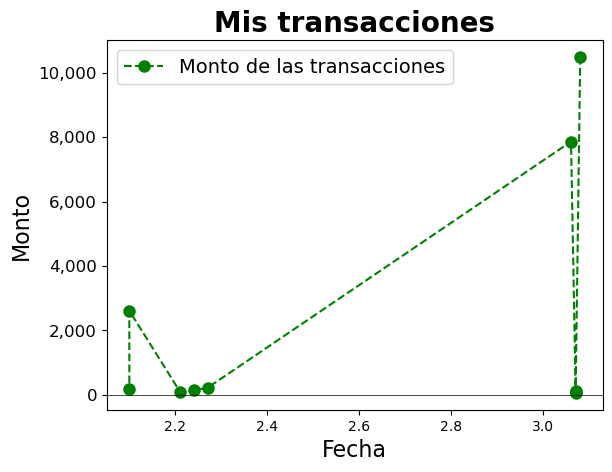

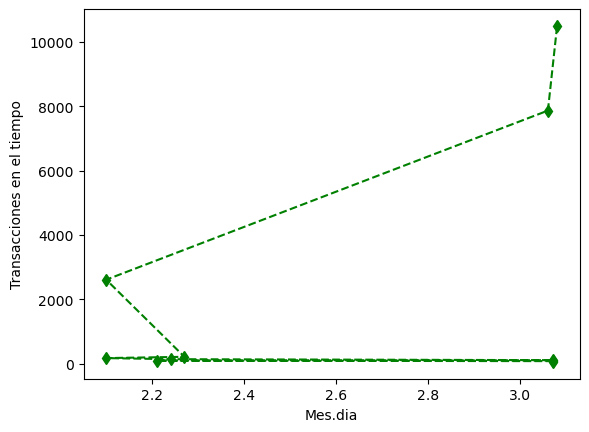

10 transacciones realizadas en total
--------------------------------------------
++Mes 2
2.1
2.1
2.21
2.24
2.27
5 transacciones realizadas en el mes 2

++Mes 3
3.06
3.07
3.07
3.07
3.08
5 transacciones realizadas en el mes 3


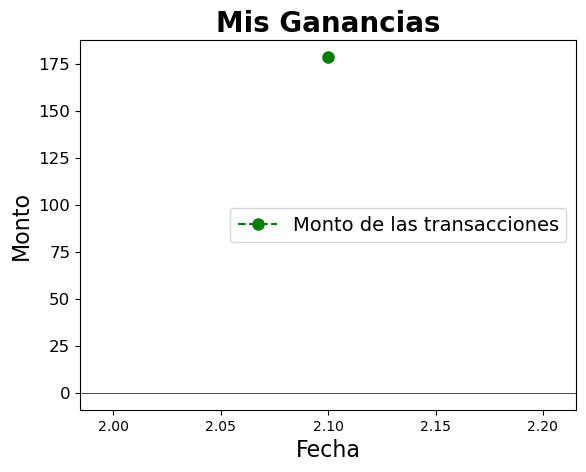

1 transacciones realizadas en total
--------------------------------------------
++Mes 2
2.1
1 transacciones realizadas en el mes 2


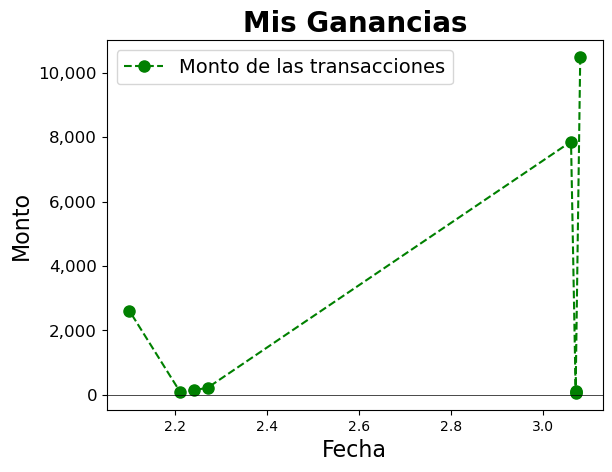

9 transacciones realizadas en total
--------------------------------------------
++Mes 2
2.1
2.21
2.24
2.27
4 transacciones realizadas en el mes 2

++Mes 3
3.06
3.07
3.07
3.07
3.08
5 transacciones realizadas en el mes 3


In [101]:
#(0) Matplotlib

def print_details(amount, dates):
    print("{0} transacciones realizadas en total".format(len(amount)))
    print("--------------------------------------------")
    month = int(sorted(dates)[0])+1 
    month_trans = 0
    print("++Mes {0}".format(month-1))
    for index, date in enumerate(sorted(dates)):
        month_trans += 1
        if date > month:
            print("{0} transacciones realizadas en el mes {1}".format(month_trans-1, month-1))
            month += 1
            month_trans = 1
            print("\n++Mes {0}".format(month-1))
        print(date)
    print("{0} transacciones realizadas en el mes {1}".format(month_trans, month-1)) #para imprimir el último mes

def plot_details(amount, dates, titulo):
    # Convertir los valores de la lista "amount" a números (floats)
    float_amount = [float(a.replace('$','').replace(',','').replace('DOP','').strip()[2:]) for a in amount]

    # Crear el gráfico
    fig, ax = plt.subplots()
    ax.plot(dates, float_amount, color='green', linestyle='--', marker='o', markersize=8)

    # Configurar el eje y
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_tick_params(labelsize=12)

    # Añadir títulos y etiquetas
    ax.set_title(titulo, fontsize=20, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=16)
    ax.set_ylabel('Monto', fontsize=16)

    # Añadir una línea horizontal en el valor cero para destacar el punto de equilibrio
    ax.axhline(y=0, color='black', linewidth=0.5)

    # Añadir una leyenda
    ax.legend(['Monto de las transacciones'], fontsize=14)

    # Mostrar el gráfico
    plt.show()


#(1) Aquí preparo los datos
amount = []
for transaction in df["Efecto"]:
    amount.append(transaction[:])
print(amount)
dates = []
for date in df["Fecha"]:
    dates.append(float("{0}.{1}".format(date[3:], date[:2])))
print(dates)

#(1) Aquí hago los plot (faltaría condicionar optimizar el plot para que sea más acertada la visualización)

#(2) Plot general
##########
#(3) Gráfica 1
plot_details(amount, dates, 'Mis transacciones')

#(3) Gráfica 2
# crea una lista de tuplas que contenga la fecha y la transacción
data = list(zip(dates, amount))

# ordena la lista por el valor de la transacción
sorted_data = sorted(data, key=lambda x: float(x[1].replace('$', '').replace(',', '').replace('DOP', '')[2:]))

# separa la lista en dos listas distintas de fechas y transacciones
sorted_dates = [x[0] for x in sorted_data]
sorted_amount = [float(x[1].replace('$', '').replace(',', '').replace('DOP', '')[2:]) for x in sorted_data]

# crea el plot con las transacciones ordenadas
plot1 = plt.subplot()
plot1.plot(sorted_dates, sorted_amount, 'g--d')
# plot1.invert_yaxis()
plt.ylabel('Transacciones en el tiempo')
plt.xlabel('Mes.dia')
plt.show()

#(3) detalles 
print_details(amount, dates)

###########

#(2) Plot de ganancias en el tiempo
earns = []
earn_dates = []
for index, trans in enumerate(amount):
    if "+" in trans:
        earns.append(trans)
        earn_dates.append(dates[index])

plot_details(earns, earn_dates, 'Mis Ganancias')
print_details(earns, earn_dates)


###########

#(2) Plot de perdidas en el tiempo
loses = []
lose_dates = []
for index, trans in enumerate(amount):
    if "-" in trans:
        loses.append(trans)
        lose_dates.append(dates[index])
plot_details(loses, lose_dates, 'Mis Gastos')
print_details(loses, lose_dates)


Debajo están las evaluaciones de la cuenta de Banreservas

In [ ]:
#leer csv, pandas


In [ ]:
#Matplotlib


Primero hay un bloque que le da formato a todos los csv en una copia para que todos los datos puedan ser leidos juntos. Luego:

Debajo están las evaluaciones de la cuenta en conjunto. Todos mis datos financieros. 

In [ ]:
#dar formato a todos los csv de las cuentas. adaptar las dimesiones en largo, número y nombre de columnas

In [ ]:
#Matplotlib
